In [1]:
!pip install tensorflow

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
testpath= r'/content/drive/MyDrive/E-Waste classification dataset/modified-dataset/test'
trainpath= r'/content/drive/MyDrive/E-Waste classification dataset/modified-dataset/train'
validpath = r'/content/drive/MyDrive/E-Waste classification dataset/modified-dataset/val'

In [25]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [26]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [27]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [28]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


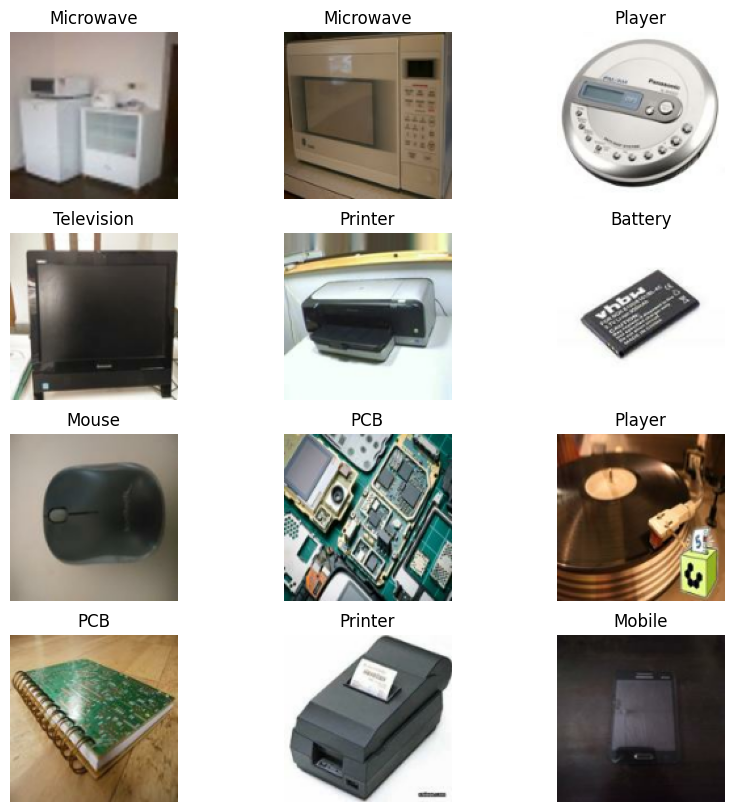

In [29]:
# set the figure size so the grid looks clear
plt.figure(figsize=(10, 10))

# take one sample batch from the training dataset
for images, labels in datatrain.take(1):

    # show the first 12 images from the batch
    for i in range(12):

        # create a 4x3 grid and select the current slot
        ax = plt.subplot(4, 3, i + 1)

        # convert tensor to numpy and display the image
        plt.imshow(images[i].numpy().astype("uint8"))

        # show the class name as the title
        plt.title(class_names[labels[i]])

        # hide axis marks to keep the grid clean
        plt.axis("off")


In [30]:
# create a data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [34]:
# load the efficientnetv2b0 model as the feature extractor
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

# freeze the first 100 layers to keep pretrained features stable
for layer in base_model.layers[:100]:
    layer.trainable = False

In [35]:
# build the final classification model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [36]:
# define early stopping to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(

    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [37]:
# set how many epochs the model should train
epochs = 15

# train the model using training data and validate on validation set
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    batch_size=100,
    callbacks=[early]
)


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - Accuracy: 0.2791 - loss: 2.0754 - val_Accuracy: 0.8000 - val_loss: 1.1083
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - Accuracy: 0.7620 - loss: 1.0116 - val_Accuracy: 0.9067 - val_loss: 0.4806
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - Accuracy: 0.8691 - loss: 0.5068 - val_Accuracy: 0.9367 - val_loss: 0.2827
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - Accuracy: 0.9125 - loss: 0.3234 - val_Accuracy: 0.9500 - val_loss: 0.2145
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - Accuracy: 0.9309 - loss: 0.2498 - val_Accuracy: 0.9533 - val_loss: 0.1784
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - Accuracy: 0.9446 - loss: 0.2084 - val_Accuracy: 0.9567 - val_loss: 0.1522
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - Accuracy: 0.9591 - loss: 0.1524 - val_Accuracy: 0.9500 - val_loss: 0.1532
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - Accuracy: 0.9674 - loss: 0.1274 - val_Accu

In [38]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - Accuracy: 0.9442 - loss: 0.1895
Test accuracy is0.9533, Test loss is 0.1520


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


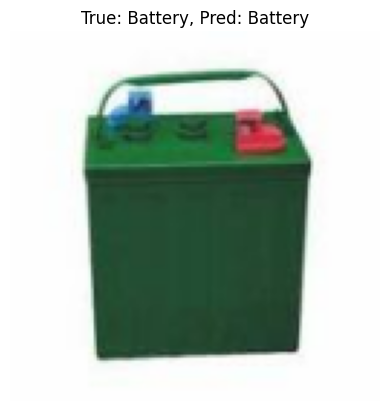

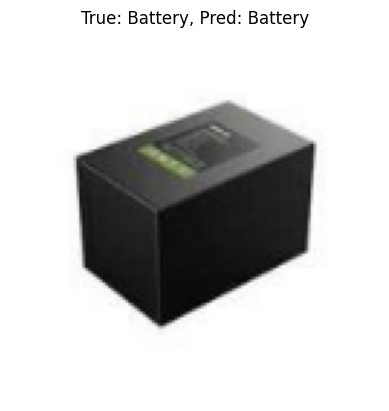

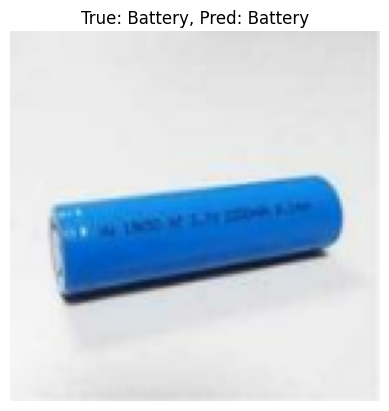

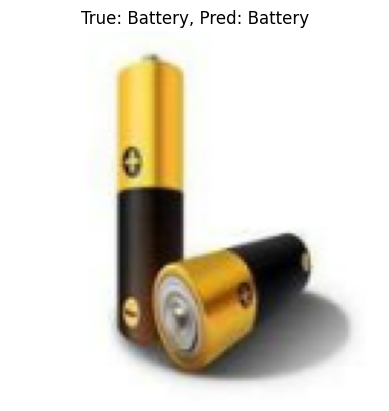

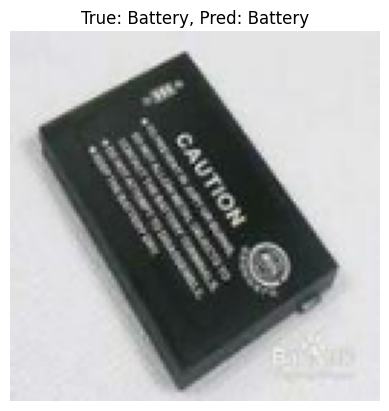

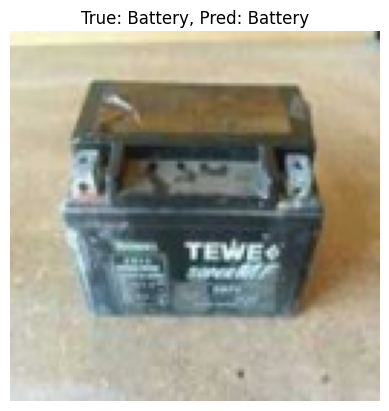

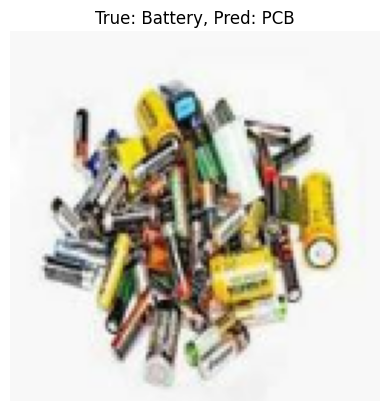

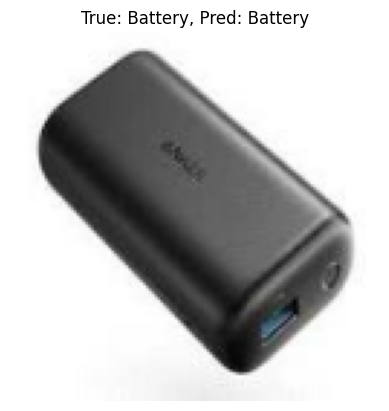

In [39]:
# display sample predictions: true labels vs predicted labels

class_names = datatest.class_names

for images, labels in datatest.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()



In [40]:
# save the trained model in keras
model.save('Efficient_classify.keras')

In [41]:
# define the class labels for prediction output
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# load the saved keras model for inference
model = tf.keras.models.load_model('Efficient_classify.keras')

In [42]:
!pip install gradio

In [43]:
def classify_image(img):

    # resize the image and convert it to an array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # preprocess the image and add a batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # make prediction using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # get index of highest score

    # get the class name and confidence score
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"predicted: {class_name} (confidence: {confidence:.2f})"


In [44]:
# create a gradio interface for the classify_image function
iface = gr.Interface(

    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text"
)

# launch the gradio app in the browser
iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://499a333a7e8e1147c4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
